# Training RL to do Cartpole Balancing

This notebooks is part of [AI for Beginners Curriculum](http://aka.ms/ai-beginners). It has been inspired by [official PyTorch tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) and [this Cartpole Pytorch implementation](https://github.com/yc930401/Actor-Critic-pytorch).

In this example, we will use RL to train a model to balance a pole on a cart that can move left and right on horizontal scale. We will use [OpenAI Gym](https://www.gymlibrary.ml/) environment to simulate the pole.

> **Note**: You can run this lesson's code locally (eg. from Visual Studio Code), in which case the simulation will open in a new window. When running the code online, you may need to make some tweaks to the code, as described [here](https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7).

We will start by making sure Gym is installed:

In [1]:
import sys
!{sys.executable} -m pip install gym

Defaulting to user installation because normal site-packages is not writeable


Now let's create the CartPole environment and see how to operate on it. An environment has the following properties:

* **Action space** is the set of possible actions that we can perform at each step of the simulation
* **Observation space** is the space of observations that we can make

In [2]:
import gym

env = gym.make("CartPole-v1")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/home/leo/.local/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/leo/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Let's see how the simulation works. The following loop runs the simulation, until `env.step` does not return the termination flag `done`. We will randomly chose actions using `env.action_space.sample()`, which means the experiment will probably fail very fast (CartPole environment terminates when the speed of CartPole, its position or angle are outside certain limits).

> Simulation will open in the new window. You can run the code several times and see how it behaves.

In [3]:
env.reset()

done = False
total_reward = 0
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   total_reward += rew
   print(f"{obs} -> {rew}")
print(f"Total reward: {total_reward}")

/home/leo/.local/lib/python3.10/site-packages/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


[-0.03742469  0.21191828 -0.01393784 -0.2686444 ] -> 1.0
[-0.03318632  0.40723634 -0.01931073 -0.56569064] -> 1.0
[-0.02504159  0.21239054 -0.03062454 -0.2791534 ] -> 1.0
[-0.02079378  0.01771855 -0.03620761  0.00371545] -> 1.0
[-0.02043941 -0.17686592 -0.0361333   0.28475815] -> 1.0
[-0.02397673 -0.3714544  -0.03043814  0.56582946] -> 1.0
[-0.03140582 -0.17591895 -0.01912155  0.2637147 ] -> 1.0
[-0.0349242   0.01947064 -0.01384726 -0.03493749] -> 1.0
[-0.03453479  0.2147884  -0.01454601 -0.331957  ] -> 1.0
[-0.03023902  0.01987648 -0.02118515 -0.04389644] -> 1.0
[-0.02984149  0.21529572 -0.02206307 -0.34318748] -> 1.0
[-0.02553557  0.4107245  -0.02892683 -0.6427453 ] -> 1.0
[-0.01732108  0.21601741 -0.04178173 -0.35931018] -> 1.0
[-0.01300073  0.41170764 -0.04896794 -0.6648696 ] -> 1.0
[-0.00476658  0.2172998  -0.06226533 -0.38799822] -> 1.0
[-4.2058565e-04  4.1324776e-01 -7.0025288e-02 -6.9964474e-01] -> 1.0
[ 0.00784437  0.21916293 -0.08401819 -0.42980158] -> 1.0
[ 0.01222763  0.415

Youn can notice that observations contain 4 numbers. They are:
- Position of cart
- Velocity of cart
- Angle of pole
- Rotation rate of pole

`rew` is the reward we receive at each step. You can see that in CartPole environment you are rewarded 1 point for each simulation step, and the goal is to maximize total reward, i.e. the time CartPole is able to balance without falling.

During reinforcement learning, our goal is to train a **policy** $\pi$, that for each state $s$ will tell us which action $a$ to take, so essentially $a = \pi(s)$.

If you want probabilistic solution, you can think of policy as returning a set of probabilities for each action, i.e. $\pi(a|s)$ would mean a probability that we should take action $a$ at state $s$.

## Policy Gradient Method

In simplest RL algorithm, called **Policy Gradient**, we will train a neural network to predict the next action.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

num_inputs = 4
num_actions = 2

model = torch.nn.Sequential(
    torch.nn.Linear(num_inputs, 128, bias=False, dtype=torch.float32),
    torch.nn.ReLU(),
    torch.nn.Linear(128, num_actions, bias = False, dtype=torch.float32),
    torch.nn.Softmax(dim=1)
)

We will train the network by running many experiments, and updating our network after each run. Let's define a function that will run the experiment and return the results (so-called **trace**) - all states, actions (and their recommended probabilities), and rewards:

In [5]:
def run_episode(max_steps_per_episode = 10000,render=False):    
    states, actions, probs, rewards = [],[],[],[]
    state = env.reset()
    for _ in range(max_steps_per_episode):
        if render:
            env.render()
        action_probs = model(torch.from_numpy(np.expand_dims(state,0)))[0]
        action = np.random.choice(num_actions, p=np.squeeze(action_probs.detach().numpy()))
        nstate, reward, done, info = env.step(action)
        if done:
            break
        states.append(state)
        actions.append(action)
        probs.append(action_probs.detach().numpy())
        rewards.append(reward)
        state = nstate
    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)

You can run one episode with untrained network and observe that total reward (AKA length of episode) is very low:

In [6]:
s, a, p, r = run_episode()
print(f"Total reward: {np.sum(r)}")

Total reward: 35.0


One of the tricky aspects of policy gradient algorithm is to use **discounted rewards**. The idea is that we compute the vector of total rewards at each step of the game, and during this process we discount the early rewards using some coefficient $gamma$. We also normalize the resulting vector, because we will use it as weight to affect our training: 

In [7]:
eps = 0.0001

def discounted_rewards(rewards,gamma=0.99,normalize=True):
    ret = []
    s = 0
    for r in rewards[::-1]:
        s = r + gamma * s
        ret.insert(0, s)
    if normalize:
        ret = (ret-np.mean(ret))/(np.std(ret)+eps)
    return ret

Now let's do the actual training! We will run 300 episodes, and at each episode we will do the following:

1. Run the experiment and collect the trace
1. Calculate the difference (`gradients`) between the actions taken, and by predicted probabilities. The less the difference is, the more we are sure that we have taken the right action.
1. Calculate discounted rewards and multiply gradients by discounted rewards - that will make sure that steps with higher rewards will make more effect on the final result than lower-rewarded ones
1. Expected target actions for our neural network would be partly taken from the predicted probabilities during the run, and partly from calculated gradients. We will use `alpha` parameter to determine to which extent gradients and rewards are taken into account - this is called *learning rate* of reinforcement algorithm.
1. Finally, we train our network on states and expected actions, and repeat the process 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_on_batch(x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    optimizer.zero_grad()
    predictions = model(x)
    loss = -torch.mean(torch.log(predictions) * y)
    loss.backward()
    optimizer.step()
    return loss

0 -> 12.0
100 -> 117.0
200 -> 499.0


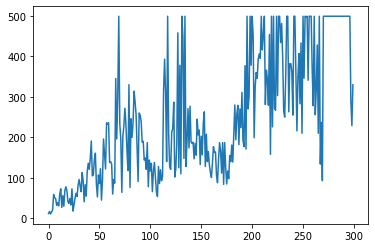

In [9]:
alpha = 1e-4

history = []
for epoch in range(300):
    states, actions, probs, rewards = run_episode()
    one_hot_actions = np.eye(2)[actions.T][0]
    gradients = one_hot_actions-probs
    dr = discounted_rewards(rewards)
    gradients *= dr
    target = alpha*np.vstack([gradients])+probs
    train_on_batch(states,target)
    history.append(np.sum(rewards))
    if epoch%100==0:
        print(f"{epoch} -> {np.sum(rewards)}")

plt.plot(history)

Now let's run the episode with rendering to see the result:

In [10]:
_ = run_episode(render=True)

/home/leo/.local/lib/python3.10/site-packages/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Hopefully, you can see that pole can now balance pretty well!

## Actor-Critic Model

Actor-Critic model is the further development of policy gradients, in which we build a neural network to learn both the policy and estimated rewards. The network will have two outputs (or you can view it as two separate networks):
* **Actor** will recommend the action to take by giving us the state probability distribution, as in policy gradient model
* **Critic** would estimate what the reward would be from those actions. It returns total estimated rewards in the future at the given state.

Let's define such a model: 

In [11]:
from itertools import count
import torch.nn.functional as F

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

class Actor(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = torch.nn.Linear(self.state_size, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = torch.distributions.Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = torch.nn.Linear(self.state_size, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

/home/leo/.local/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/leo/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


We would need to slightly modify our `discounted_rewards` and `run_episode` functions:

In [13]:
def discounted_rewards(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def run_episode(actor, critic, n_iters):
    optimizerA = torch.optim.Adam(actor.parameters())
    optimizerC = torch.optim.Adam(critic.parameters())
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        for i in count():
            env.render()
            state = torch.FloatTensor(state).to(device)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.cpu().numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            state = next_state

            if done:
                print('Iteration: {}, Score: {}'.format(iter, i))
                break


        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)
        returns = discounted_rewards(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()


Now we will run the main training loop. We will use manual network training process by computing proper loss functions and updating network parameters:

In [14]:

actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)
run_episode(actor, critic, n_iters=100)

Iteration: 0, Score: 31
Iteration: 1, Score: 17
Iteration: 2, Score: 11
Iteration: 3, Score: 11
Iteration: 4, Score: 13
Iteration: 5, Score: 23
Iteration: 6, Score: 13
Iteration: 7, Score: 16
Iteration: 8, Score: 17
Iteration: 9, Score: 10
Iteration: 10, Score: 34
Iteration: 11, Score: 16
Iteration: 12, Score: 17
Iteration: 13, Score: 26
Iteration: 14, Score: 15
Iteration: 15, Score: 15
Iteration: 16, Score: 16
Iteration: 17, Score: 14
Iteration: 18, Score: 29
Iteration: 19, Score: 16
Iteration: 20, Score: 19
Iteration: 21, Score: 20
Iteration: 22, Score: 20
Iteration: 23, Score: 26
Iteration: 24, Score: 10
Iteration: 25, Score: 16
Iteration: 26, Score: 39
Iteration: 27, Score: 16
Iteration: 28, Score: 36
Iteration: 29, Score: 15
Iteration: 30, Score: 9
Iteration: 31, Score: 24
Iteration: 32, Score: 11
Iteration: 33, Score: 26
Iteration: 34, Score: 12
Iteration: 35, Score: 20
Iteration: 36, Score: 14
Iteration: 37, Score: 36
Iteration: 38, Score: 19
Iteration: 39, Score: 27
Iteration: 

Finally, let's close the environment.

In [ ]:
env.close()

## Takeaway

We have seen two RL algorithms in this demo: simple policy gradient, and more sophisticated actor-critic. You can see that those algorithms operate with abstract notions of state, action and reward - thus they can be applied to very different environments.

Reinforcement learning allows us to learn the best strategy to solve the problem just by looking at the final reward. The fact that we do not need labelled datasets allows us to repeat simulations many times to optimize our models. However, there are still many challenges in RL, which you may learn if you decide to focus more on this interesting area of AI.   